## Model Training & Fine Tuning

Here I'll be documenting how I used deep CNN to build a prediciton model and also use VGG16 bottleneck feature for transfer learning & fine tuning

In [1]:
import pandas as pd
import os
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras import applications,optimizers
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras_tqdm import TQDMNotebookCallback
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential,Model
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
import math

E:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Path to tensor function, convert image file to a (1,244,244,3) shape matrix as input for the model

In [19]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True        

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

### Initial Model Training

In [6]:
init_model = Sequential()
init_model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(224, 224, 3)))
init_model.add(MaxPooling2D(pool_size=2))

init_model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
init_model.add(MaxPooling2D(pool_size=2))

init_model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
init_model.add(MaxPooling2D(pool_size=2))

init_model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
init_model.add(MaxPooling2D(pool_size=2)) 


init_model.add(Flatten())
init_model.add(Dropout(0.3))
init_model.add(Dense(179, activation='softmax'))

init_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
__________

Using SGD optimizer here

ref: http://ruder.io/optimizing-gradient-descent/

- Here's first model, simillar to previous dog breed classifier CNN architecture.
- I build 4 convolutional layer and each layer with relu activation, last fully connected with 179 output using a softmax function (multi-classfication)

In [7]:
init_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

- Using keras preprocessing method to seperate train & test set.
- Added more image argumation based on existing 360 degree image
- Choosing a larger batch size to fully utilize my GPU (1080 Ti)

In [8]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img_height=224
img_width=224
batch_size=256
eph=50

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    'E:/StockX_Train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    'E:/StockX_Train', # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data



Found 33824 images belonging to 179 classes.
Found 8365 images belonging to 179 classes.


In [9]:
callbacks_list = [TQDMNotebookCallback(leave_inner=True)]

In [ ]:
init_model.fit_generator(
        train_generator,
        steps_per_epoch=int(math.ceil(train_generator.n/batch_size)),
        epochs=eph,
        validation_data=validation_generator,
        validation_steps=int(math.ceil(validation_generator.n/batch_size)),
        callbacks=callbacks_list,verbose=0)

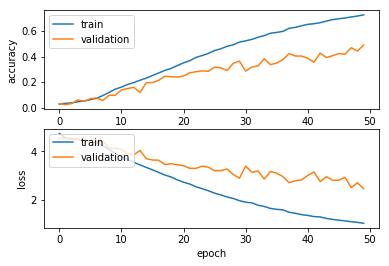

In [17]:
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(init_model.history.history['acc'])  
plt.plot(init_model.history.history['val_acc'])   
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  

# summarize history for loss  
plt.subplot(212)  
plt.plot(init_model.history.history['loss'])  
plt.plot(init_model.history.history['val_loss'])   
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show() 

- First initial model, after 50 epoch accuracy around 0.7 with validation accuracy 0.5

In [13]:
model_json = init_model.to_json()
with open("model_cnn4_256.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
init_model.save_weights("model_cnn4_256.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
key = {v: k for k, v in train_generator.class_indices.items()}

In [26]:
fail=0
succ=0
angle_succ={}
angle_fail={}

for folder in os.listdir("E:/StockX_Test"):
    for file_ in os.listdir("E:/StockX_Test/"+folder):
        angle=file_.split('_')[1].split('.')[0]
        test_input=path_to_tensor("E:/StockX_Test/"+folder+'/'+file_).astype('float32')/255
        test_output=init_model.predict_classes(test_input)
        if(key[test_output[0]]==folder):
            succ+=1
            if(angle in angle_succ):
                angle_succ[angle]=angle_succ.get(angle)+1
            else:
                angle_succ[angle]=0
        else:
            fail+=1
            if(angle in angle_fail):
                angle_fail[angle]=angle_fail.get(angle)+1
            else:
                angle_fail[angle]=0

print(succ/(fail+succ))

0.7406766628219915

- Test set accuracy 0.74

<Figure size 432x288 with 0 Axes>

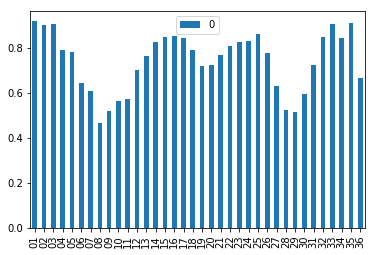

In [52]:
angle_rate={}

for key in angle_succ.keys():
    angle_rate[key]=angle_succ[key]/(angle_succ[key]+angle_fail[key])
    
angle=pd.DataFrame.from_dict(angle_rate,orient='index')

plt.figure(1)
ax=angle.sort_index().plot.bar()

- From this bar chart we can see this model performance best on the side view (0-50 degree), have more error on front and back pictures (80-90 degree & 28-290 degree) which have fewer feature in the picture for model to predict.

### Pre-trained Network Transfer Learning

In [82]:
top_model_weights_path = 'bottleneck_fc_model.h5'
top_model_json_path = 'bottleneck_fc_model.json'
epochs = 100
batch_size = 256
img_width, img_height = 224,224

In [83]:
def save_bottlebeck_features():
    model = applications.VGG16(include_top=False, weights='imagenet')
    # build the VGG16 network
    datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

    train_generator = datagen.flow_from_directory(
    'E:/StockX_Train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    subset='training',
    shuffle=False) # set as training data

    nb_train_samples = len(train_generator.filenames)  
    num_classes = len(train_generator.class_indices)  
    predict_size_train = int(math.ceil(nb_train_samples / batch_size))  

    
    validation_generator = datagen.flow_from_directory(
    'E:/StockX_Train', # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    subset='validation',
    shuffle=False)
    
    nb_validation_samples = len(validation_generator.filenames)  
    predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  

    bottleneck_features_train = model.predict_generator(
        train_generator, predict_size_train)
    np.save(open('bottleneck_features_train.npy', 'wb'),
            bottleneck_features_train)
    
    # set as validation data
    bottleneck_features_validation = model.predict_generator(
        validation_generator, predict_size_validation)
    np.save(open('bottleneck_features_validation.npy', 'wb'),
            bottleneck_features_validation)


In [84]:
def train_top_model():
    
    datagen_top = ImageDataGenerator(rescale=1./255,validation_split=0.2)
     
    train_generator_top = datagen_top.flow_from_directory(  
    'E:/StockX_Train',
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',
    subset='training',
    shuffle=False)

    nb_train_samples = len(train_generator_top.filenames)  
    num_classes = len(train_generator_top.class_indices)  

     # load the bottleneck features saved earlier  
    train_data = np.load(open('bottleneck_features_train.npy','rb'))
    train_labels = train_generator_top.classes
    train_labels = np_utils.to_categorical(train_labels, num_classes=num_classes)

    validation_generator_top = datagen_top.flow_from_directory(  
    'E:/StockX_Train',
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',
    subset='validation',
    shuffle=False)
    
    nb_validation_samples = len(validation_generator_top.filenames) 
    
    validation_data = np.load(open('bottleneck_features_validation.npy','rb'))
    validation_labels = validation_generator_top.classes  
    validation_labels = np_utils.to_categorical(validation_labels, num_classes=num_classes) 

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy'])

    chk = ModelCheckpoint("myModel.h5", monitor='val_loss', save_best_only=False) 
    callbacks_list = [chk,TQDMNotebookCallback(leave_inner=True)]

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=callbacks_list,
              verbose=0)
    model.save_weights(top_model_weights_path)
    model_json = model.to_json()
    with open(top_model_json_path, "w") as json_file:
        json_file.write(model_json)
    (eval_loss, eval_accuracy) = model.evaluate(  
     validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
     
    print("[INFO] Loss: {}".format(eval_loss))  
    
    plt.figure(1)  
 # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(model.history.history['acc'])  
    plt.plot(model.history.history['val_acc'])  
    plt.title('model accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  

    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(model.history.history['loss'])  
    plt.plot(model.history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
 

In [85]:
save_bottlebeck_features()

Found 33824 images belonging to 179 classes.
Found 8365 images belonging to 179 classes.


Found 33824 images belonging to 179 classes.
Found 8365 images belonging to 179 classes.


8365/8365 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 72us/step
[INFO] accuracy: 78.83%
[INFO] Loss: 0.8252018346732345


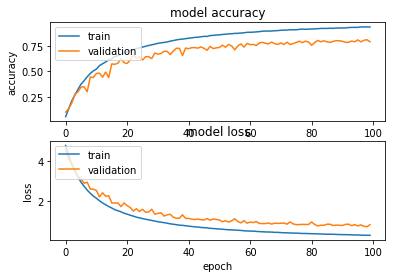

In [86]:
train_top_model()

- Here run the VGG-16 imagenet model to save the bottleneck feature.
- Train a fully connected top model on top of bottleneck feature.
- Achieved 0.83 accuracy in 100 epoch

In [17]:
 top_model_weights_path = 'bottleneck_fc_model.h5'
epochs = 50
batch_size = 128
img_width, img_height = 224,224

In [18]:
datagen_top = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_generator_top = datagen_top.flow_from_directory(  
'E:/StockX_Train',
target_size=(224, 224),  
batch_size=batch_size,  
class_mode='categorical',
subset='training',
shuffle=False)

nb_train_samples = len(train_generator_top.filenames)  
num_classes = len(train_generator_top.class_indices) 

Found 33824 images belonging to 179 classes.


In [87]:
vgg = applications.VGG16(include_top=False, weights='imagenet')  
 # get the bottleneck prediction from the pre-trained VGG16 model  
 # build top model  
vgg = Sequential()  
vgg.add(Flatten(input_shape=(7, 7, 512)))  
vgg.add(Dense(256, activation='relu'))  
vgg.add(Dropout(0.5))  
vgg.add(Dense(num_classes, activation='softmax'))  
vgg.load_weights('bottleneck_fc_model.h5')  

btn= applications.VGG16(include_top=False, weights='imagenet')  

#use the bottleneck prediction on the top model to get the final classification  
#class_predicted = vgg.predict_classes(bottleneck_prediction)  
#class_predicted=vgg.predict_classes(btn.predict(a))  

In [93]:
fail=0
succ=0
angle_succ={}
angle_fail={}

for folder in os.listdir("E:/StockX_Test"):
    for file_ in os.listdir("E:/StockX_Test/"+folder):
        angle=file_.split('_')[1].split('.')[0]
        test_input=path_to_tensor("E:/StockX_Test/"+folder+'/'+file_).astype('float32')/255
        test_output=vgg.predict_classes(btn.predict(test_input))
        if(key[test_output[0]]==folder):
            succ+=1
            if(angle in angle_succ):
                angle_succ[angle]=angle_succ.get(angle)+1
            else:
                angle_succ[angle]=0
        else:
            fail+=1
            if(angle in angle_fail):
                angle_fail[angle]=angle_fail.get(angle)+1
            else:
                angle_fail[angle]=0
            

print(succ/(succ+fail))

0.9132064590542099

- Test set accuracy 0.91, significant improved from initial model

### Fine tuning

In [25]:
top_model_weights_path = 'bottleneck_fc_model.h5'
top_model_json_path = 'bottleneck_fc_model.json'
epochs = 50
batch_size = 256
img_width, img_height = 224,224

In [ ]:
model_ft = applications.VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model_ft.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(179, activation='softmax'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model_ft=Model(input=model_ft.input,output=top_model(model_ft.output))

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model_ft.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model_ft.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


chk = ModelCheckpoint("myFineTune.h5", monitor='val_loss', save_best_only=False) 
callbacks_list = [chk,TQDMNotebookCallback(leave_inner=True)]

# prepare data augmentation configuration

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
'E:/StockX_Train',
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='categorical',
subset='training',
shuffle=False) # set as training data

nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)  
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  


validation_generator = datagen.flow_from_directory(
'E:/StockX_Train', # same directory as training data
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='categorical',
subset='validation',
shuffle=False)

nb_validation_samples = len(validation_generator.filenames)  
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  

validation_labels = validation_generator.classes  
validation_labels = np_utils.to_categorical(validation_labels, num_classes=num_classes) 

# fine-tune the model
model_ft.fit_generator(
    train_generator,
    steps_per_epoch=predict_size_train,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=predict_size_validation,
    callbacks=callbacks_list,
              verbose=0)


In [90]:
model_ft.evaluate_generator(generator=test_generator,steps=predict_size_test)

[0.2548881843199138, 0.9388696658799209]

- Freeze first 15 convolutional layer only train last few layer prevent over fitting
- Using SGD optimizer
- Result of 0.94 accuracy in 50 Epoch

In [28]:
model_ft.save_weights('fine_tune_256.h5')
model_json = model_ft.to_json()
with open('fine_tune_256.json', "w") as json_file:
        json_file.write(model_json)

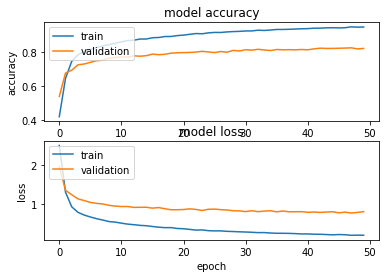

In [24]:
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(model_ft.history.history['acc'])  
plt.plot(model_ft.history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  

# summarize history for loss  
plt.subplot(212)  
plt.plot(model_ft.history.history['loss'])  
plt.plot(model_ft.history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  

In [67]:
f=0
s=0

for folder in os.listdir("E:/StockX_Test"):
    for file_ in os.listdir("E:/StockX_Test/"+folder):
        angle=file_.split('_')[1].split('.')[0]
        test_input=path_to_tensor("E:/StockX_Test/"+folder+'/'+file_).astype('float32')/255
        y_prob=model_ft.predict(test_input)
        y_classes = y_prob.argmax(axis=-1)
        if(key[y_classes[0]]==folder):
            s+=1
        else:
            f+=1

print(s/(f+s))


0.9466551326412919

- Test set accuracy 0.945, further improved from tranfser learning model